In [1]:
import numpy as np 

import jax
import optax
from jax import numpy as jnp, random as jr

from matplotlib import pyplot as plt

In [2]:
grid_size = 10
num_actions = 5  
num_states = grid_size * grid_size

embedding_dim = 10

In [3]:
action_deltas = {
    0: np.array([0, -1]), 
    1: np.array([0, 1]),  
    2: np.array([-1, 0]),  
    3: np.array([1, 0]),   
    4: np.array([0, 0])  
}

def state_to_coord(s):
    """Convert state index to (x, y) coordinates."""
    x = s % grid_size
    y = s // grid_size
    return np.array([x, y])

def coord_to_state(coord):
    """Convert (x, y) coordinate to state index."""
    x, y = coord
    return int(y * grid_size + x)

def get_next_state(s, a):
    """Given state and action, return next state (with boundaries)."""
    coord = state_to_coord(s)
    delta = action_deltas[a]
    new_coord = coord + delta
    new_coord[0] = np.clip(new_coord[0], 0, grid_size - 1)
    new_coord[1] = np.clip(new_coord[1], 0, grid_size - 1)
    return coord_to_state(new_coord)


dataset = []
for s in range(num_states):
    for a in range(num_actions):
        s_next = get_next_state(s, a)
        dataset.append((s, a, s_next))
dataset = np.array(dataset)

In [4]:
def init_params(key):
    """Initialize model parameters."""
    keys = jr.split(key, 3)
    state_emb = jr.normal(keys[0], (num_states, embedding_dim))
    W = jr.normal(keys[1], (embedding_dim + num_actions, embedding_dim)) * 0.1
    b = jr.normal(keys[2], (embedding_dim,)) * 0.1
    return {"state_emb": state_emb, "W": W, "b": b}


def predict_next_emb(params, s, a):
    """Given state index s and action a, predict the next state's embedding."""
    state_vec = params["state_emb"][s]
    a_onehot = jax.nn.one_hot(a, num_classes=num_actions)
    inp = jnp.concatenate([state_vec, a_onehot])
    return jnp.dot(inp, params["W"]) + params["b"]


v_predict_next_emb = jax.vmap(predict_next_emb, in_axes=(None, 0, 0))


def loss_fn(params, batch):
    s, a, s_next = (
        batch[:, 0].astype(int),
        batch[:, 1].astype(int),
        batch[:, 2].astype(int),
    )
    pred_emb = v_predict_next_emb(params, s, a)  
    true_emb = params["state_emb"][s_next] 
    return jnp.mean(jnp.sum((pred_emb - true_emb) ** 2, axis=1))

In [5]:
num_epochs = 1000
batch = jnp.array(dataset)

learning_rate = 0.05
optimizer = optax.adam(learning_rate)
key = jr.PRNGKey(0)
params = init_params(key)
opt_state = optimizer.init(params)

@jax.jit
def update(params, opt_state, batch):
    grads = jax.grad(loss_fn)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

loss_history = []
for epoch in range(num_epochs):
    params, opt_state = update(params, opt_state, batch)
    if epoch % 100 == 0:
        current_loss = loss_fn(params, batch)
        loss_history.append(current_loss)
        print(f"Epoch {epoch}, Loss: {current_loss:.4f}")

Epoch 0, Loss: 8.8476
Epoch 100, Loss: 0.0025
Epoch 200, Loss: 0.0006
Epoch 300, Loss: 0.0004
Epoch 400, Loss: 0.0003
Epoch 500, Loss: 0.0002
Epoch 600, Loss: 0.0001
Epoch 700, Loss: 0.0001
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


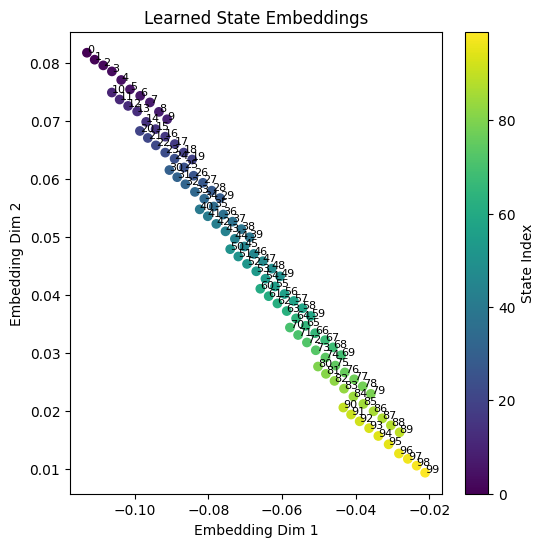

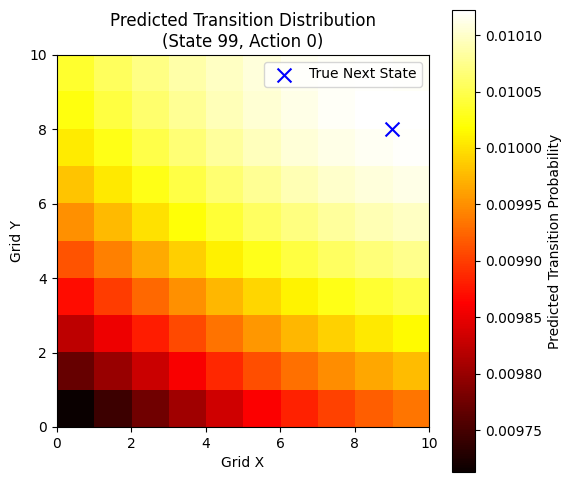

In [14]:
def transition_distribution(params, s, a):
    pred_emb = predict_next_emb(params, s, a)
    all_emb = params["state_emb"]
    distances = jnp.sum((all_emb - pred_emb) ** 2, axis=1)
    return jax.nn.softmax(-distances)


state_embs = np.array(params["state_emb"])
coords = np.array([state_to_coord(s) for s in range(num_states)])
plt.figure(figsize=(6, 6))
plt.scatter(
    state_embs[:, 0],
    state_embs[:, 1],
    c=coords[:, 0] + coords[:, 1] * grid_size,
    cmap="viridis",
)
for s in range(num_states):
    plt.text(state_embs[s, 0], state_embs[s, 1], str(s), fontsize=8)
plt.xlabel("Embedding Dim 1")
plt.ylabel("Embedding Dim 2")
plt.title("Learned State Embeddings")
plt.colorbar(label="State Index")
plt.show()


sample_state = 99
sample_action = 0

probs = transition_distribution(params, sample_state, sample_action)
prob_grid = probs.reshape((grid_size, grid_size))

plt.figure(figsize=(6, 6))
plt.imshow(prob_grid, origin="lower", cmap="hot", extent=[0, grid_size, 0, grid_size])
plt.colorbar(label="Predicted Transition Probability")
plt.scatter(
    *state_to_coord(get_next_state(sample_state, sample_action)),
    color="blue",
    marker="x",
    s=100,
    label="True Next State",
)
plt.xlabel("Grid X")
plt.ylabel("Grid Y")
plt.title(
    f"Predicted Transition Distribution\n(State {sample_state}, Action {sample_action})"
)
plt.legend()
plt.show()